# Lista de Exercícios 4: Gradiente de Política

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido **antes** de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps4.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 01/07/2025. **Não serão aceitas submissões fora do prazo.**
- ***SUBMISSÕES QUE NÃO SEGUIREM ESTAS INSTRUÇÕES NÃO SERÃO AVALIADAS.***
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Cart Pole

Cart Pole é um ambiente no qual o agente precisa equilibrar um pêndulo invertido acoplado a um carrinho que se move horizontalmente. O objetivo é evitar que o pêndulo caia, controlando a posição do carrinho de maneira apropriada. O desafio está em manter o equilíbrio do sistema aplicando forças para a esquerda ou para a direita, de modo a contrabalançar a inclinação do pêndulo.

![Cart Pole](https://gymnasium.farama.org/_images/cart_pole.gif)

O espaço de observação é contínuo e composto por quatro variáveis: a posição e a velocidade do carrinho, o ângulo do pêndulo e a velocidade angular do pêndulo. O agente pode escolher entre duas ações discretas: aplicar uma força no carrinho para a esquerda ou para a direita. O estado inicial de cada episódio é definido de forma aleatória, com todos os valores dentro do intervalo $(−0.05, 0.05)$. O sempre sistema começa em uma configuração próxima do equilíbrio vertical, mas com pequenas variações.

O episódio termina quando o ângulo do pêndulo em relação ao eixo vertical excede 12 graus, quando o carrinho se afasta mais de 2.4 unidades de distância do centro, ou quando o limite de 500 passos é atingido. A cada passo, o agente recebe uma recompensa de $1$, incentivando-o a manter o sistema estável pelo maior tempo possível. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

Nesta lista de exercícios, você irá trabalhar com o ambiente Cart Pole descrito acima. Seu objetivo será implementar o algoritmo REINFORCE para solucionar este problema.

## REINFORCE

Nesta atividade, você implementará um agente baseado no algoritmo REINFORCE, utilizando uma **política linear com softmax**. Não é permitido o uso de bibliotecas de aprendizado profundo. Você será responsável por definir e inicializar os pesos da política, calcular o gradiente da função objetivo e realizar a atualização dos parâmetros ao longo do treinamento.

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, e o fator de desconto $\gamma$.
2. Implemente o método `softmax`, que recebe um vetor de preferências (logits) $z = (z_1,\dotsc,z_K) \in \mathbb{R}^K$ e retorna as probabilidades de cada ação segundo a função softmax $\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$, para $i = 1, \dotsc, K.$
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo REINFORCE. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [18]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [19]:
class ReinforceAgent:
    def __init__(self, observation_space, action_space, alpha, gamma):
        self.observation_space = observation_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        
        (self.n_features, ) = observation_space.shape
        self.n_actions = action_space.n
        
        self.weights = np.random.randn(self.n_features, self.n_actions) * 0.1
        
        self.trajectories = []

    def softmax(self, z):
        return np.exp(z - np.max(z)) / np.sum(np.exp(z - np.max(z)))

    def choose_action(self, state):
        logits = np.dot(state, self.weights)
        
        action_probs = self.softmax(logits)
        
        action = np.random.choice(self.n_actions, p=action_probs)
        
        return action

    def learn(self, trajectories):
        for trajectory in trajectories:
            returns = []
            G = 0
            
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                G = reward + self.gamma * G
                returns.insert(0, G)
            
            for t in range(len(trajectory)):
                state, action, reward = trajectory[t]
                G = returns[t]
                
                logits = np.dot(state, self.weights)
                action_probs = self.softmax(logits)
                
                grad_log_pi = np.zeros((self.n_features, self.n_actions))
                
                for a in range(self.n_actions):
                    grad_log_pi[:, a] = (
                        state * (1 - action_probs[a])
                        if a == action else
                        state * (-action_probs[a])
                    )
                    
                self.weights += self.alpha * G * grad_log_pi

    def train(self, env, episodes):
        episode_returns = []
        
        for _ in range(episodes):
            state, _ = env.reset()
            trajectory = []
            episode_return = 0
            
            done = False
            while not done:
                action = self.choose_action(state)
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                trajectory.append((state, action, reward))
                episode_return += reward
                
                state = next_state
            
            self.learn([trajectory])
            
            episode_returns.append(episode_return)
        
        return episode_returns

In [14]:
# Não altere ou remova esta célula

6. Treine um novo agente no ambiente Cart Pole por 2000 episódios. Escolha parâmetros $\alpha$ e $\gamma$ de acordo com o desempenho do seu modelo. Armazene os retornos episódicos, obtidos no método train, na variável `reinforce_returns`.

In [20]:
env = gym.make("CartPole-v1")

agent = ReinforceAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=0.01,
    gamma=0.99
)

reinforce_returns = agent.train(env, episodes=2000)

env.close()

In [ ]:
# Não altere ou remova esta célula

## Análise

7. Utilize a biblioteca matplotlib para gerar um gráfico dos retornos episódicos obtidos pelo agente, armazenados na variável `reinforce_returns` no exercício anterior. Caso os dados apresentem muita variação, aplique uma média móvel para suavizar a curva e evidenciar melhor a tendência de aprendizado. Adicione um título e rótulos de eixos apropriados para facilitar a interpretação.

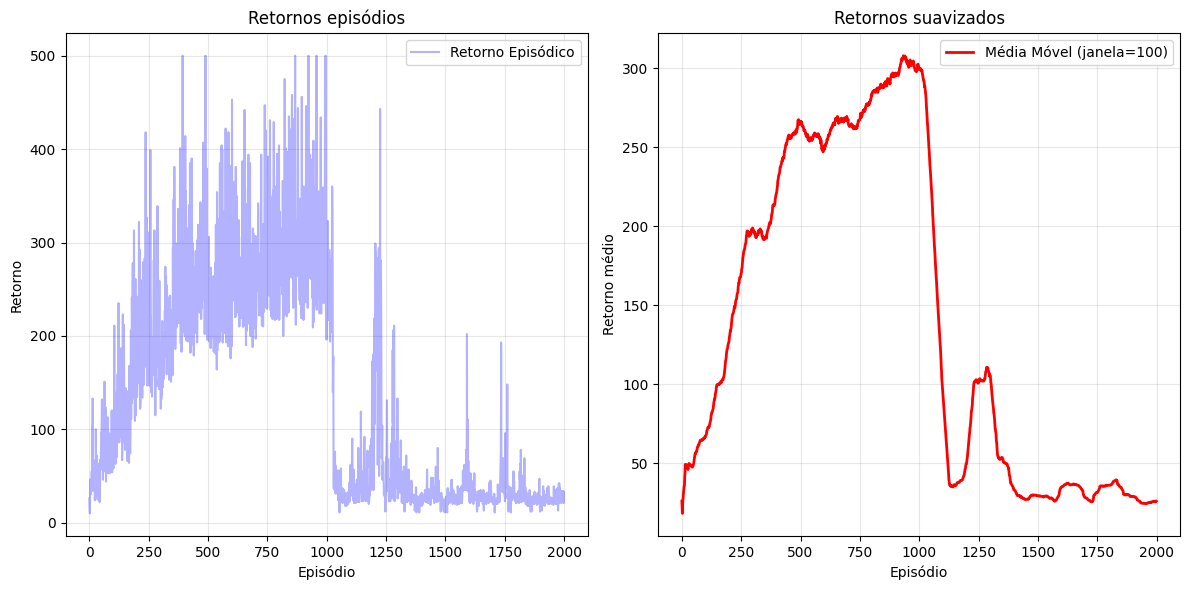

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(reinforce_returns, alpha=0.3, color='blue', label='Retorno Episódico')
plt.title('Retornos episódios')
plt.xlabel('Episódio')
plt.ylabel('Retorno')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
window_size = 100
if len(reinforce_returns) >= window_size:
    moving_avg = []
    for i in range(len(reinforce_returns)):
        if i < window_size:
            moving_avg.append(np.mean(reinforce_returns[:i+1]))
        else:
            moving_avg.append(np.mean(reinforce_returns[i-window_size+1:i+1]))
    
    plt.plot(moving_avg, color='red', linewidth=2, label=f'Média Móvel (janela={window_size})')
else:
    plt.plot(reinforce_returns, color='red', linewidth=2, label='Retorno Episódico')

plt.title('Retornos suavizados')
plt.xlabel('Episódio')
plt.ylabel('Retorno médio')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

8. Durante o treinamento, o seu agente apresentou instabilidades, como variações bruscas na recompensa ou dificuldade em convergir? Que estratégias poderiam ser adotadas para mitigar instabilidades neste algoritmo?

Ao longo do meu treinamento, o agente apresentou instabilidade durante o treinamento. Isso ficou bem claro ao observar os gráficos, que mostram variações muito bruscas na recompensa a cada episódio e uma clara dificuldade de convergir para uma política estável. Essa instabilidade é uma característica conhecida do REINFORCE e acontece, em grande parte, pela alta variância na estimativa do gradiente, já que o algoritmo se baseia em uma única trajetória para cada atualização. Para tentar estabilizar o aprendizado, poderíamos adotar algumas estratégias, como introduzir um baseline, que ajudaria a reduzir a variância dos retornos. Outras abordagens seriam usar uma taxa de aprendizado adaptativa, que diminui com o tempo, ou até mesmo limitar a magnitude dos gradientes para evitar atualizações muito grandes e abruptas nos pesos da política.

9. Explique qual é o papel da função softmax na definição da política. Por que, nesse contexto, não é suficiente escolher apenas a ação com maior valor?

O papel da função softmax na nossa política é pegar os scores de preferência para cada ação, que são a saída do modelo linear, e converter esses valores em uma distribuição de probabilidade. Essencialmente, ela nos diz a chance de escolher cada ação possível em um determinado estado. Se simplesmente a ação com o maior valor for escolhida, adotando uma política gulosa, o agente não conseguiria aprender de forma eficaz. O principal motivo é a falta de exploração, ou seja, ele ficaria "preso" na primeira estratégia que desse um resultado razoável, sem nunca explorar outras ações que poderiam levar a uma solução muito melhor. Além disso, do ponto de vista do algoritmo, o REINFORCE precisa de uma política estocástica para funcionar, pois seu método de atualização se baseia em calcular o gradiente da log-probabilidade da ação. Sem as probabilidades geradas pelo softmax, não teríamos como calcular esse gradiente e, consequentemente, não haveria aprendizado.

10. Por que o algoritmo REINFORCE precisa aguardar a conclusão de todo o episódio antes de realizar atualizações nos parâmetros da política?

Isso se deve ao fato de se tratar de um método de Monte Carlo, pois depende de uma amostra completa da interação para poder fazer a atualização. Ou seja, o algoritmo REINFORCE precisa esperar o episódio terminar porque a forma como ele avalia se uma ação foi boa ou ruim depende do retorno total que o agente recebeu depois daquela ação, até o fim do episódio. Na implementação, isso fica claro no método learn, onde primeiro percorremos a trajetória completa de trás para frente para calcular esses retornos (G). Esse valor G é o que "pesa" na hora de atualizar a política; se ele foi alto, a probabilidade do agente escolher aquela ação aumenta, caso contrário, diminui. Não teríamos como saber esse retorno completo sem antes ver o desfecho de todas as ações no episódio. 